<a href="https://colab.research.google.com/github/BreakoutMentors/Data-Science-and-Machine-Learning/blob/adam-medical-cnn/Intro_to_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os
files.upload()
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

!kaggle datasets download -d preetviradiya/covid19-radiography-dataset
!unzip covid19-radiography-dataset.zip && rm covid19-radiography-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-671.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL

dataframe = pd.read_csv("/content/metadata.csv")
dataframe.head()

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,COVID-1.png,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,COVID-10.png,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,COVID-100.png,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,COVID-1000.png,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,COVID-1001.png,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID


In [23]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

root = "/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"

means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)

# Add more transforms tomorrow
transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize(means, stds), # Means and STDs of ImageNet
])

# Using ImageFolder to read in the images with their labeled folders
dataset = ImageFolder(root, transform=transforms)

# Calculating the amount of images to split the dataset
trainToTestRatio = 0.8
trainSize = int(trainToTestRatio * len(dataset))
testSize = len(dataset) - trainSize

# Calculating the amount to split the training set into validation set
valSize = int(trainSize * 0.1) # Taking 10% of training data
trainSize = trainSize - valSize # Updating the amount of training data

# Splitting Data
training_data, val_data, testing_data = torch.utils.data.random_split(dataset, lengths=[trainSize, valSize, testSize])

# Loading Data
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

Batch Image Dimensions: torch.Size([16, 3, 255, 255])
Batch Label Dimensions: torch.Size([16])


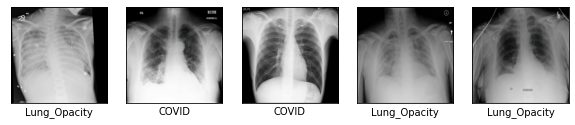

In [29]:
import torchvision.transforms.functional as F

# Function to reverse normalization of the images
def unNormalizeTensor(tensor, means, stds):
  for channel, mean, std in zip(tensor, means, stds):
    channel.mul_(std).add_(mean)
  return tensor

images, labels = next(iter(train_dataloader))
print("Batch Image Dimensions:", images.size())
print("Batch Label Dimensions:", labels.size())

idx_to_class = {value:key for key,value in dataset.class_to_idx.items()}
plt.figure(figsize=(10, 9))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = F.to_pil_image(unNormalizeTensor(images[i], means, stds))
  plt.imshow(image)
  plt.xlabel(idx_to_class[labels[i].item()])

In [5]:
dataset.class_to_idx

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [6]:
import torch.nn as nn

# Should we use OOP or nn.Sequential to build models